In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import compute_rsquared
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [23]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [24]:
data, all_gdps, all_gts = load_data()

Data shape : (502, 191)
         date      country  Expense_average_1y_diff  Expense_average_2y_diff  \
0  2006-03-01  Switzerland                 3.988984                 4.615121   

        GDP  
0  0.098917  


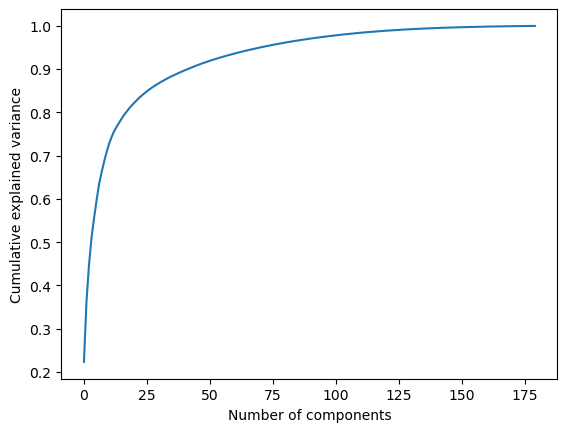

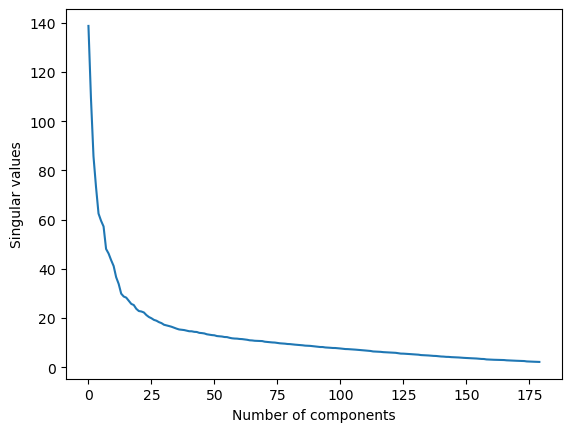

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


In [25]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, _ = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE, 
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': True})



In [26]:
all_gts['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Simplified kernel (removed WhiteKernel to reduce complexity)
kernel = C(1.0, (1e-1, 10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10))

# Create the GaussianProcessRegressor with minimal restarts
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)

# Define an even smaller parameter grid
param_dist = {
    "kernel__k1__constant_value": [1, 10],  # Reduced range
    "kernel__k2__length_scale": [1, 10],  # Reduced range
    "alpha": [1e-1],  # Single value
}

# Perform Randomized Search with very few samples and minimal folds
random_search = RandomizedSearchCV(
    gp,
    param_distributions=param_dist,
    n_iter=3,  # Only 3 parameter settings sampled
    cv=2,  # Minimal cross-validation
    n_jobs=-1,  # Parallel processing
    random_state=42  # For reproducibility
)

# Fit the model
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=2,
                   estimator=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                                                      n_restarts_optimizer=1),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'alpha': [0.1],
                                        'kernel__k1__constant_value': [1, 10],
                                        'kernel__k2__length_scale': [1, 10]},
                   random_state=42)

In [28]:
gp.set_params(**random_search.best_params_)
gp.fit(X_train, y_train)

# Predict on the validation set
y_pred, sigma = gp.predict(X_valid, return_std=True)
y_pred_train, sigma_train = gp.predict(X_train, return_std=True)

In [29]:
# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_valid = mean_squared_error(y_valid, y_pred)
print(f"Training MSE: {mse_train:.4f}")
print(f"Validation MSE: {mse_valid:.4f}")

# MAPE
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
mape_valid = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f"Training MAPE: {mape_train:.2f}%")
print(f"Validation MAPE: {mape_valid:.2f}%")

# R^2
r2_train = compute_rsquared(y_train, y_pred_train)
r2_valid = compute_rsquared(y_valid, y_pred)
print(f"Training R^2: {r2_train:.4f}")
print(f"Validation R^2: {r2_valid:.4f}")

Training MSE: 0.0012
Validation MSE: 0.3448
Training MAPE: 21.81%
Validation MAPE: 80.53%
Training R^2: 0.9988
Validation R^2: 0.5549


In [30]:
# Associate the result by country
y_pred_country = pd.DataFrame({'date': preprocessor.dates_valid, 'country': preprocessor.country_valid, 'y_pred': y_pred, 'y_true': y_valid, 'y_std': sigma})
y_pred_train_country = pd.DataFrame({'date': preprocessor.dates_train, 'country': preprocessor.country_train, 'y_pred': y_pred_train, 'y_true': y_train, 'y_std': sigma_train})
y_pred_train_country

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)


In [31]:
# Plot the predictions per country, per date
def plot_by_country(selected_country, country_valid):
    plt.figure(figsize=(15, 5))
    plt.plot(y_pred_country[country_valid == selected_country]['y_true'].values, label="True")
    plt.plot(y_pred_country[country_valid == selected_country]['y_pred'].values, label="Predicted")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_country[country_valid == selected_country]['y_pred'].values - 3 * y_pred_country[country_valid == selected_country]['y_std'].values, y_pred_country[country_valid == selected_country]['y_pred'].values + 3 * y_pred_country[country_valid == selected_country]['y_std'].values, alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_country[country_valid == selected_country]['y_pred'].values - 1.96 * y_pred_country[country_valid == selected_country]['y_std'].values, y_pred_country[country_valid == selected_country]['y_pred'].values + 1.96 * y_pred_country[country_valid == selected_country]['y_std'].values, alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(preprocessor.country_valid), country_valid=widgets.fixed(preprocessor.country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country, country_valid)>

In [33]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country_with_confidence(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = preprocessor.splitting_date # predictions['date'].quantile(TRAIN_PROPORTION)


    unmelted_data = predictions[(predictions["country"] == selected_country)]
    unmelted_data = unmelted_data.sort_values("date")
    
    plt.figure(figsize=(12, 6))
    
    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )
    
    plt.fill_between(
        unmelted_data["date"],
        unmelted_data["y_pred"] - 1.96 * unmelted_data["y_std"],
        unmelted_data["y_pred"] + 1.96 * unmelted_data["y_std"],
        color="red", alpha=0.2, label="Confidence Interval"
    )
    
    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    
    # Enhancing the plot
    plt.title(f"Prediction vs True Values with Confidence Intervals for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country_with_confidence, selected_country=dropdown)
plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…